In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
d_model = 64
name = f"pix2pix_{d_model}"
output_dir = f"./output/{name}"

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


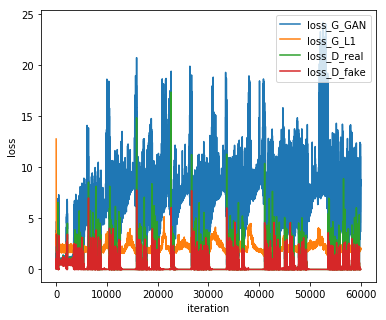

In [3]:
# loss function
fname = f"{output_dir}/loss_log.txt"

df = pd.read_csv(fname, sep=" ", header=0)
header = df.columns

plt.figure(figsize=(6,5))
plt.xlabel("iteration")
plt.ylabel("loss")

epoch = df["#iter"]
for i, key in enumerate(header[3:]):
    plt.plot(epoch, df[key], label=key)
plt.legend(loc="upper right")

In [ ]:
# reproduced mapp
suffix = f"run1_index0"
f_realA = f"./val_data/{suffix}_z1.3_ha.fits"
f_realB = f"./val_data/{suffix}_z2.0_oiii.fits"
f_fakeA = f"{output_dir}/test/gen_{suffix}.fits"

f_list = [ f_realA, f_realB, f_fakeA ]
data = [ fits.open( f )[0].data for f in f_list ]

label_list = ["observed", "true", "reconstructed"]
data = [ data[0]+data[1], data[1], data[2] ]

vmin = 0
vmax = np.max(data[0])

fig = plt.figure(figsize=(9,3))
for i, (d, l) in enumerate(zip(data, label_list)):
    ax = plt.subplot2grid((1,3), (0,i))
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.title(l)
    im = plt.imshow(d, interpolation="none", vmin=vmin, vmax=vmax)    

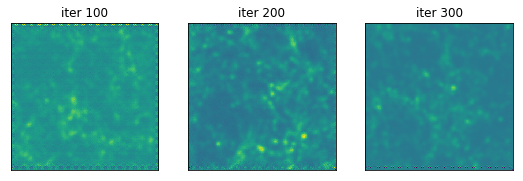

In [40]:
# reproduced mapp
suffix = f"run0_index0"
freq = 100:q
    c
nmap = 3

plt.figure(figsize=(nmap*3, 3))
for i in range(nmap):
    iter = freq * (i+1)
    fname = "{}/iter_{:d}.fits".format(output_dir, iter)
    data = fits.open( fname )[0].data

    ax = plt.subplot2grid((1,nmap), (0,i))
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.title("iter {:d}".format(iter))
    im = plt.imshow(data, interpolation="none")    